In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [3]:
df = pd.read_csv('output.csv')
rqst_df = pd.read_csv('send_request_ns.csv')

column_names = df.columns.values

print("Column names:", column_names)
print("Data shape:", df.shape)

column_names_rqst = rqst_df.columns.values

print("Column names:", column_names_rqst)
print("Data shape:", rqst_df.shape)

# convert ns to ms
for x in column_names:
    if not 'ns' in x:
        continue
    print(x)
    df[x] = df[x] / 1_000_000


Column names: ['test_id' 'query_id' 'pre1_ns' 'pre2_ns' 'pre3_ns' 'pre1_fix_ns'
 'post1_ipc_ns' 'post1_ipc_noop_ns' 'post2_ipc_ns' 'post3_ipc_ns'
 'post4_ipc_ns' 'post5_ipc_ns' 'post1_tcp_ns' 'post2_tcp_ns'
 'post3_tcp_ns' 'request_counter']
Data shape: (679, 16)
Column names: ['send_request_ns']
Data shape: (196, 1)
pre1_ns
pre2_ns
pre3_ns
pre1_fix_ns
post1_ipc_ns
post1_ipc_noop_ns
post2_ipc_ns
post3_ipc_ns
post4_ipc_ns
post5_ipc_ns
post1_tcp_ns
post2_tcp_ns
post3_tcp_ns


In [15]:
df['pre_mean_ns'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].mean(axis=1)
df['pre_median_ns'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].median(axis=1)
df['pre_std'] = df[['pre1_ns', 'pre2_ns', 'pre3_ns', 'pre1_fix_ns']].std(axis=1) / np.sqrt(4)
df['post_mean_ipc_ns'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns', 'post5_ipc_ns']].mean(axis=1)
df['post_median_ipc_ns'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns', 'post5_ipc_ns']].median(axis=1)
df['post_ipc_std'] = df[['post1_ipc_ns', 'post2_ipc_ns', 'post3_ipc_ns', 'post4_ipc_ns', 'post5_ipc_ns']].std(axis=1) / np.sqrt(5)
df['post_mean_tcp_ns'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].mean(axis=1)
df['post_median_tcp_ns'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].median(axis=1)
df['post_tcp_std'] = df[['post1_tcp_ns', 'post2_tcp_ns', 'post3_tcp_ns']].std(axis=1) / np.sqrt(3)
print(df['pre_mean_ns'].mean())
print(df['post_mean_ipc_ns'].mean())
print(df['post_mean_tcp_ns'].mean())

send_request_mean = rqst_df['send_request_ns'].mean() / 1_000_000
print(send_request_mean)
df['min_overhead'] = df['request_counter'] * send_request_mean
print(df['min_overhead'].head())

df['introduced_overhead'] = df['post_mean_ipc_ns'] - df['pre_mean_ns']
print(df['introduced_overhead'].mean())
print(df['introduced_overhead'].median())

df['unique_id'] = df['test_id'].astype(str) + '-' + df['query_id'].astype(str)
print(df['unique_id'].head())

148.51922212739322
392.04797060883647
406.7821243662249
0.005357765306122449
0    0.080366
1    1.216213
2    0.878674
3    4.816631
4    0.321466
Name: min_overhead, dtype: float64
243.5287484814433
-9.065132349999999
0    1505-1
1    1506-1
2    1506-2
3    1506-3
4    1506-4
Name: unique_id, dtype: object


In [5]:
df_filtered = df[df['query_id'] != 1]

df_ = df#df_filtered

count = (df_['post_mean_tcp_ns'] < df_['post_mean_ipc_ns']).sum()

print(f"Evaluation True for {count} / {len(df_)} queries,")
print(f"Percentage: {count/len(df_)*100:.2f}%")

Evaluation True for 314 / 679 queries,
Percentage: 46.24%


In [6]:
# Create safe copy
df_copy = df.copy()

# Add fastest column using loc and nested np.where()
df_copy.loc[:, 'fastest_mean_ns'] = np.where(
    df_copy['pre_mean_ns'] <= df_copy[['post_mean_ipc_ns', 'post_mean_tcp_ns']].min(axis=1),
    'pre_mean_ns',
    np.where(
        df_copy['post_mean_ipc_ns'] <= df_copy['post_mean_tcp_ns'],
        'post_mean_ipc_ns',
        'post_mean_tcp_ns'
    )
)

# Reassign back to original
df = df_copy
print(df['fastest_mean_ns'].value_counts())

fastest_mean_ns
post_mean_tcp_ns    265
post_mean_ipc_ns    242
pre_mean_ns         172
Name: count, dtype: int64


Total entries: 679
Valid pre_mean_ns values: 679


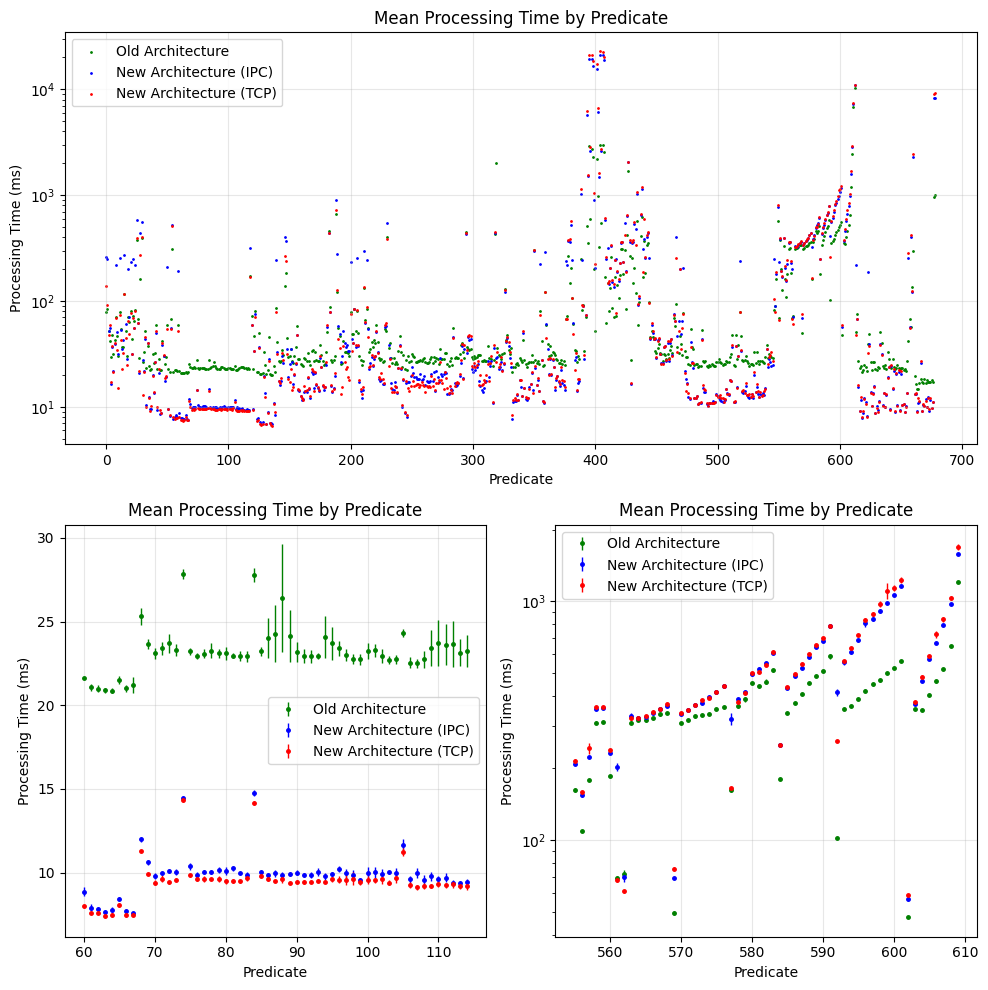

In [7]:

df_mask = df

print(f"Total entries: {len(df_mask)}")
print(f"Valid pre_mean_ns values: {df_mask['pre_mean_ns'].count()}")

# rohdaten

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].remove()
axs[0][1].remove()
axs[0][0] = fig.add_subplot(2, 1, 1)
# axs[0][0].errorbar(range(len(df_mask)), df_mask['pre_mean_ns'], yerr=stdandardabweichung_pre, fmt='.',elinewidth=1, markersize='5', color='green', alpha=1, label='Old Architecture')
axs[0][0].scatter(range(len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
axs[0][0].scatter(range(len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
axs[0][0].scatter(range(len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')
axs[0][0].set_xlabel('Predicate')
axs[0][0].set_ylabel('Processing Time (ms)')
axs[0][0].set_yscale('log')  # Apply log scale to y-axis if needed
axs[0][0].set_title('Mean Processing Time by Predicate')
axs[0][0].grid(True, alpha=0.3)
axs[0][0].legend()

offset = 60
df_mask = df[offset:115]
# nicht standardabweichung der grundgesamtheit sondern standardfehler des mitelwertes
# also statistische messunsicherheiten ohne die systematischen messunsicherheiten

# axs[1][0].scatter(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
# axs[1][0].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
# axs[1][0].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')
axs[1][0].errorbar(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], yerr=df_mask['pre_std'] , fmt='.', elinewidth=1, markersize='5', color='green', alpha=1, label='Old Architecture')
axs[1][0].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], yerr=df_mask['post_ipc_std'],  fmt='.', elinewidth=1, markersize='5', color='blue', alpha=1, label='New Architecture (IPC)')
axs[1][0].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], yerr=df_mask['post_tcp_std'], fmt='.', elinewidth=1, markersize='5', color='red', alpha=1, label='New Architecture (TCP)')
axs[1][0].set_xlabel('Predicate')
axs[1][0].set_ylabel('Processing Time (ms)')
axs[1][0].set_title('Mean Processing Time by Predicate')
axs[1][0].grid(True, alpha=0.3)
axs[1][0].legend()

offset = 555
df_mask = df[offset:610]

# axs[1][1].scatter(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
# axs[1][1].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
# axs[1][1].scatter(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')
axs[1][1].errorbar(range(offset, offset+len(df_mask)), df_mask['pre_mean_ns'], yerr=df_mask['pre_std'] , fmt='.', elinewidth=1, markersize='5', color='green', alpha=1, label='Old Architecture')
axs[1][1].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_ipc_ns'], yerr=df_mask['post_ipc_std'],  fmt='.', elinewidth=1, markersize='5', color='blue', alpha=1, label='New Architecture (IPC)')
axs[1][1].errorbar(range(offset, offset+len(df_mask)), df_mask['post_mean_tcp_ns'], yerr=df_mask['post_tcp_std'], fmt='.', elinewidth=1, markersize='5', color='red', alpha=1, label='New Architecture (TCP)')
axs[1][1].set_xlabel('Predicate')
axs[1][1].set_ylabel('Processing Time (ms)')
axs[1][1].set_yscale('log')  # Apply log scale to y-axis if needed
axs[1][1].set_title('Mean Processing Time by Predicate')
axs[1][1].grid(True, alpha=0.3)
axs[1][1].legend()


plt.tight_layout()
# plt.show()
plt.savefig('processingtime.pdf')
plt.savefig('processingtime.png')

# -> 


(array([  0.02635929, -13.13223059]), array([[ 4.04273093e-08, -3.08536464e-06],
       [-3.08536464e-06,  1.41544495e-02]]))
     test_id  query_id    pre1_ns      pre2_ns      pre3_ns  pre1_fix_ns  \
319     2122        90  36.431769  4032.839388  3993.312955    42.535669   

     post1_ipc_ns  post1_ipc_noop_ns  post2_ipc_ns  post3_ipc_ns  \
319     31.168074          24.935008      32.01447     30.883189   

     post4_ipc_ns  post5_ipc_ns  post1_tcp_ns  post2_tcp_ns  post3_tcp_ns  \
319     25.089715     25.646602     28.382167     25.774042      25.20377   

     request_counter  pre_mean_ns  pre_median_ns      pre_std  \
319              119  2026.279945    2017.924312  1147.106388   

     post_mean_ipc_ns  post_median_ipc_ns  post_ipc_std  post_mean_tcp_ns  \
319          28.96041           30.883189      1.480908         26.453326   

     post_median_tcp_ns  post_tcp_std  min_overhead  introduced_overhead  \
319           25.774042       0.97837      0.637574         -1997.3

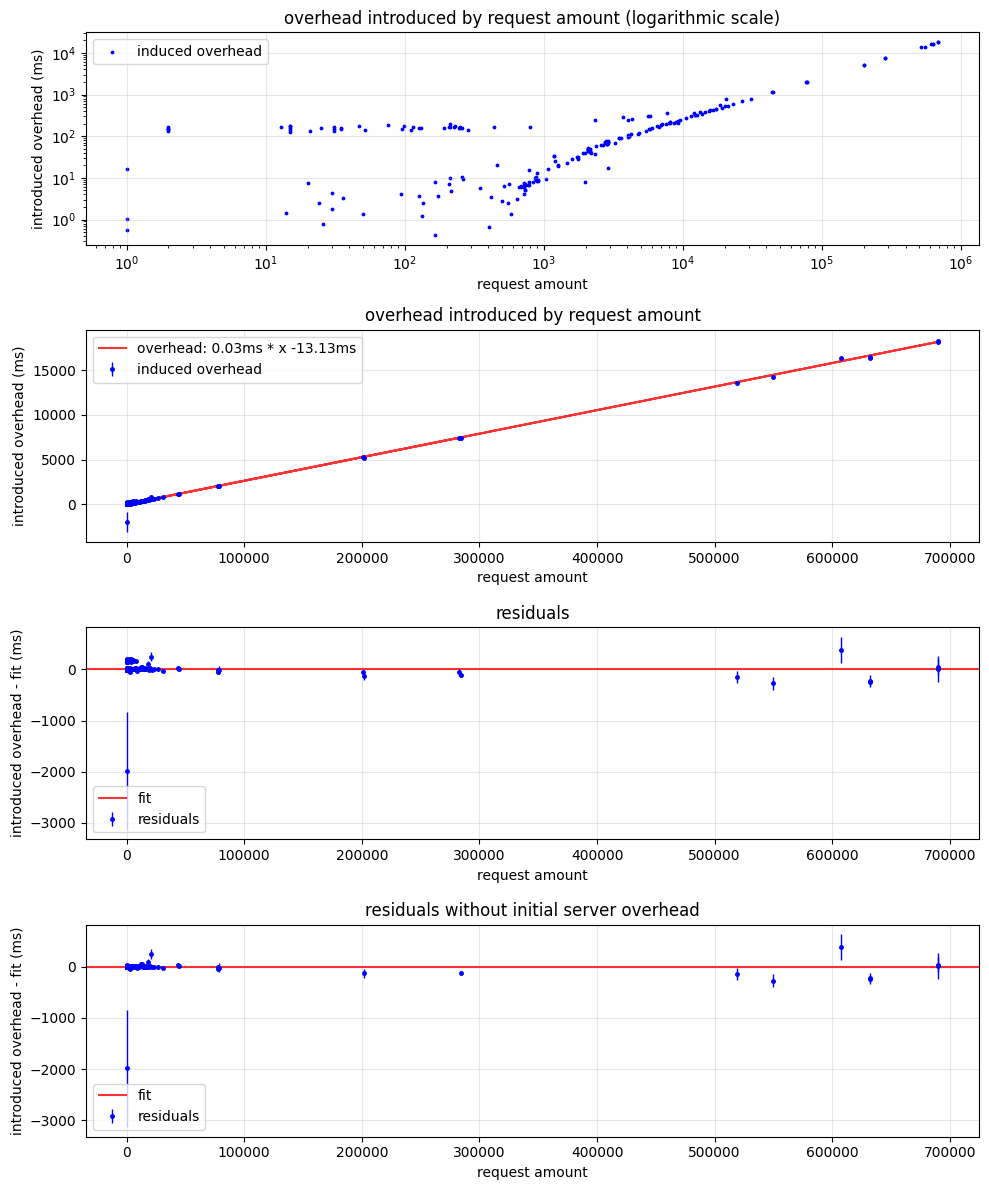

In [8]:
# systematiken erkennen
# initialer overhead ist sichtbar
# ein grooßer ausreißer bei dem was falsch lief
# 


# es wird angenommen dass die messfehler normalverteilt sind
df_mask = df

fig, axs = plt.subplots(4, 1, figsize=(10, 12))

axs[0].scatter(df_mask['request_counter'], df_mask['introduced_overhead'], s=3, color='blue', label='induced overhead')
axs[0].set_xlabel('request amount')
axs[0].set_ylabel('introduced overhead (ms)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_title('overhead introduced by request amount (logarithmic scale)')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

x = df_mask['request_counter']
y = (df_mask['introduced_overhead']).values

stdandardabweichung_res = np.sqrt(df_mask['pre_std']**2 + df_mask['post_ipc_std']**2)

f = lambda x,a,b: a*x + b
fitted = curve_fit(f, x, y, sigma=stdandardabweichung_res)
print(fitted)
fitted_f = f(x, fitted[0][0], fitted[0][1])


axs[1].errorbar(df_mask['request_counter'], df_mask['introduced_overhead'], yerr=stdandardabweichung_res , fmt='.', elinewidth=1, markersize='5', color='blue', ecolor='blue', alpha=1, label='induced overhead')
axs[1].plot(df_mask['request_counter'], fitted_f, alpha=0.8, color='red', label=f'overhead: {fitted[0][0]:.2f}ms * x {fitted[0][1]:.2f}ms')
axs[1].set_xlabel('request amount')
axs[1].set_ylabel('introduced overhead (ms)')
axs[1].set_title('overhead introduced by request amount')
axs[1].grid(True, alpha=0.3)
axs[1].legend()


df_mask['fit_diff'] = df_mask['introduced_overhead'] - fitted_f


stdandardabweichung_res = np.sqrt(df_mask['pre_std']**2 + df_mask['post_ipc_std']**2)

axs[2].errorbar(df_mask['request_counter'], df_mask['fit_diff'], yerr=stdandardabweichung_res , fmt='.', elinewidth=1, markersize='5', color='blue', ecolor='blue', alpha=1, label='residuals')
axs[2].axhline(0, alpha=0.8, color='red', label='fit')
axs[2].set_xlabel('request amount')
axs[2].set_ylabel('introduced overhead - fit (ms)')
axs[2].set_title('residuals')
# axs[2].set_yscale('log')
# axs[2].set_xscale('log')
axs[2].grid(True, alpha=0.3)
axs[2].legend()



df_mask = df[df['query_id'] != 1]


stdandardabweichung_res = np.sqrt(df_mask['pre_std']**2 + df_mask['post_ipc_std']**2)

axs[3].errorbar(df_mask['request_counter'], df_mask['fit_diff'], yerr=stdandardabweichung_res , fmt='.', elinewidth=1, markersize='5', color='blue', ecolor='blue', alpha=1, label='residuals')
axs[3].axhline(0, alpha=0.8, color='red', label='fit')
axs[3].set_xlabel('request amount')
axs[3].set_ylabel('introduced overhead - fit (ms)')
axs[3].set_title('residuals without initial server overhead')
axs[3].grid(True, alpha=0.3)
axs[3].legend()

plt.tight_layout()
# plt.show()
plt.savefig('overhead.pdf')
plt.savefig('overhead.png')

pd.set_option('display.max_columns', None)
df_mask = df[df['introduced_overhead'] < -1800]
print(df_mask.head())



0    179.937312
1    166.074152
2      0.429029
3     13.345827
4    -12.908774
Name: introduced_overhead, dtype: float64
463


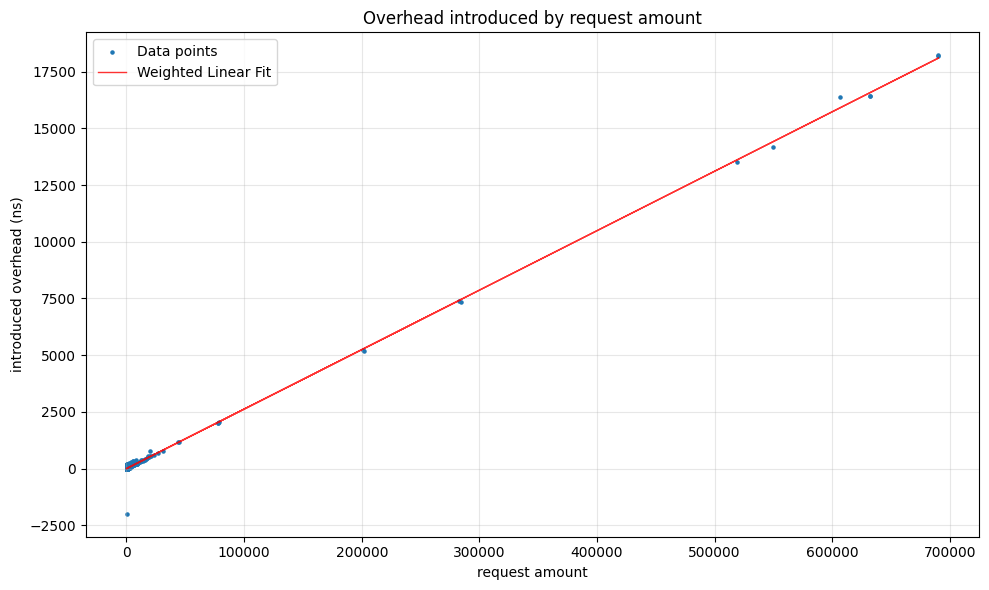

Intercept: -2.5338027933043747
Slope: [0.02622786]


In [9]:

print(df['introduced_overhead'].head())
print((df['introduced_overhead'] < 0).sum())
# Calculate frequency (clumping points)
try:
    freq = df.groupby(['request_counter', 'introduced_overhead']).size().reset_index(name='count')
    df = pd.merge(df, freq, on=['request_counter', 'introduced_overhead'], how='left')
    df['weight'] = 1 / df['count']
except (KeyError, pd.errors.MergeError) as e:
    pass
# Weights as inverse frequency

# Extract X, y, and weights
X = df['request_counter'].values.reshape(-1, 1)  # Reshape for sklearn
y = df['introduced_overhead'].values
weights = df['weight'].values

# Fit weighted regression
model = LinearRegression()
model.fit(X, y, sample_weight=weights)

# Predict values
y_pred = model.predict(X)

# Plot data and weighted regression line
plt.figure(figsize=(10, 6))
plt.scatter(df['request_counter'], y, s=5, label='Data points')
plt.plot(df['request_counter'], y_pred, color='red', linewidth=1, alpha=0.8, label='Weighted Linear Fit')
plt.xlabel('request amount')
plt.ylabel('introduced overhead (ns)')
plt.title('Overhead introduced by request amount')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display coefficients
print("Intercept:", model.intercept_)
print("Slope:", model.coef_)

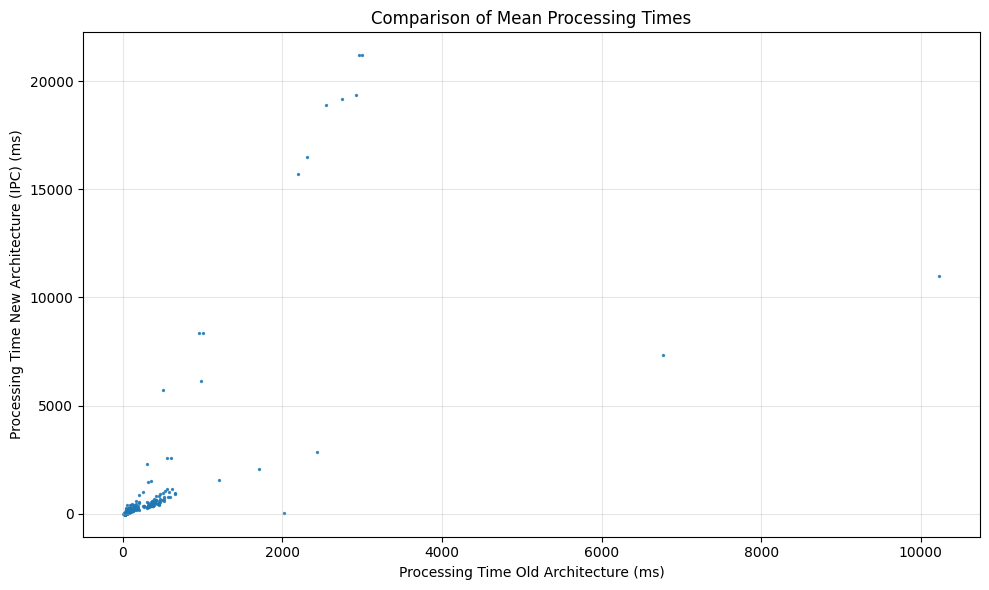

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['pre_mean_ns'], df['post_mean_ipc_ns'], s=2, alpha=0.8)
plt.xlabel('Processing Time Old Architecture (ms)')
plt.ylabel('Processing Time New Architecture (IPC) (ms)')
plt.title('Comparison of Mean Processing Times')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


(429,)
fastest_mean_ns
post_mean_ipc_ns    215
post_mean_tcp_ns    208
pre_mean_ns           6
Name: count, dtype: int64
26.929943309440556 16.490343313752913 16.114072076146076 93.40326340326341


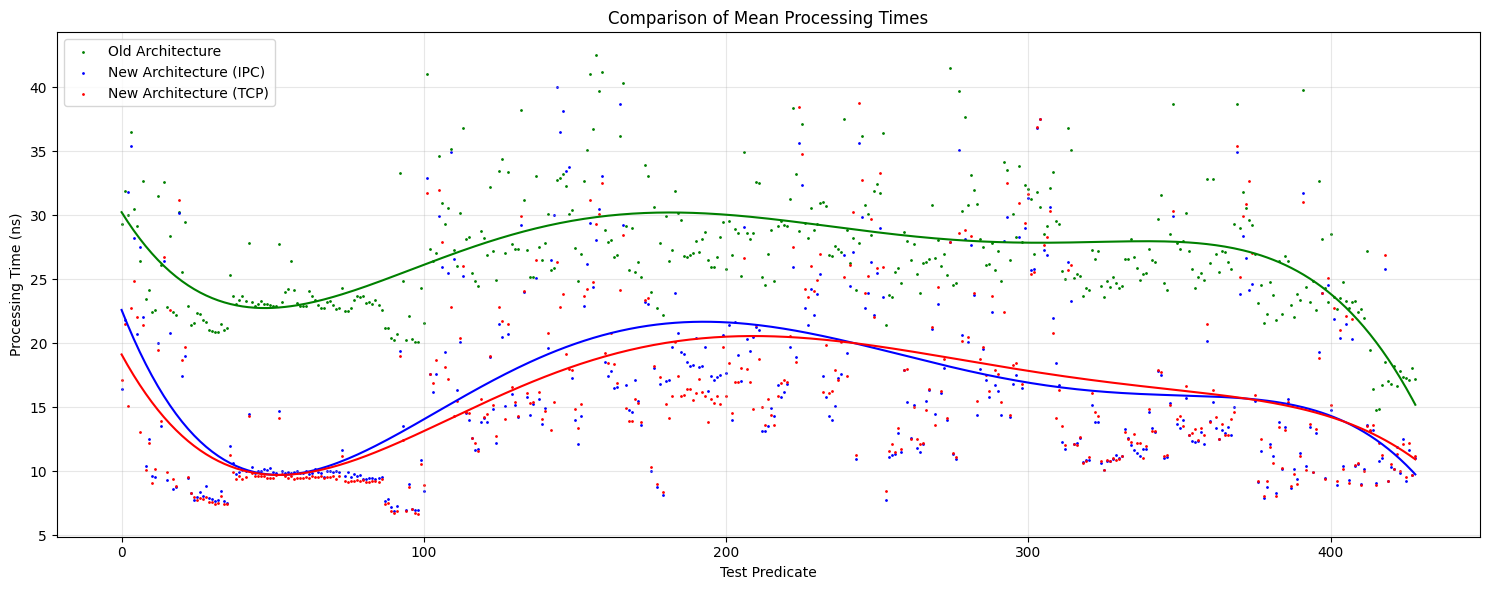

In [11]:
tolerance = 25
quantile = 0.95
df_mask = df#[(df['query_id'] != 1)]

# find the entries, such that at most tolerance entries have pre_mean_ns as fastest mean time
while df_mask['fastest_mean_ns'].value_counts().get('pre_mean_ns', 0) > tolerance:
    x = df_mask['pre_mean_ns'].quantile(quantile)
    df_mask = df[(df['pre_mean_ns'] < x) & 
                 (df['post_mean_ipc_ns'] < x) & 
                 (df['post_mean_tcp_ns'] < x)]


# invert the mask
# df_mask = df[(df['pre_mean_ns'] >= x) & 
#                 (df['post_mean_ipc_ns'] >= x) & 
#                 (df['post_mean_tcp_ns'] >= x)]

# df_mask = df[(df['pre_mean_ns'] < df['post_mean_ipc_ns'])]

# exclude the top 5% of values (extremes)

df_mask = df_mask[(df_mask['pre_mean_ns'] < df_mask['pre_mean_ns'].quantile(quantile)) &
    (df_mask['post_mean_ipc_ns'] < df_mask['post_mean_ipc_ns'].quantile(quantile)) &
    (df_mask['post_mean_tcp_ns'] < df_mask['post_mean_tcp_ns'].quantile(quantile))]


print(df_mask['fastest_mean_ns'].shape)
print(df_mask['fastest_mean_ns'].value_counts())
print(df_mask['pre_mean_ns'].mean(), df_mask['post_mean_ipc_ns'].mean(), df_mask['post_mean_tcp_ns'].mean(), df_mask['request_counter'].mean())

# Plot the data
plt.figure(figsize=(15, 6))
# Create line plots for each mean time
# plt.plot(df_mask.index, df_mask['pre_mean_ns'], color='green', alpha=0.5, label='pre_mean_ns')
# plt.plot(df_mask.index, df_mask['post_mean_ipc_ns'], color='blue', alpha=0.5, label='post_mean_ipc_ns')
# plt.plot(df_mask.index, df_mask['post_mean_tcp_ns'], color='red', alpha=0.5, label='post_mean_tcp_ns')
# Create scatter plots for each mean time
plt.scatter(range(len(df_mask)), df_mask['pre_mean_ns'], s=1, color='green', alpha=1, label='Old Architecture')
plt.scatter(range(len(df_mask)), df_mask['post_mean_ipc_ns'], s=1, color='blue', alpha=1, label='New Architecture (IPC)')
plt.scatter(range(len(df_mask)), df_mask['post_mean_tcp_ns'], s=1, color='red', alpha=1, label='New Architecture (TCP)')


pre_mean_ns_x = np.arange(len(df_mask['pre_mean_ns']))
pre_mean_ns_y = df_mask['pre_mean_ns'].values
post_mean_ipc_ns_x = np.arange(len(df_mask['post_mean_ipc_ns']))
post_mean_ipc_ns_y = df_mask['post_mean_ipc_ns'].values
post_mean_tcp_ns_x = np.arange(len(df_mask['post_mean_tcp_ns']))
post_mean_tcp_ns_y = df_mask['post_mean_tcp_ns'].values

# Fit polynomial (degree=3 for cubic fit)
pre_mean_ns_coefficients = np.polyfit(pre_mean_ns_x, pre_mean_ns_y, 5)
pre_mean_ns_polynomial = np.poly1d(pre_mean_ns_coefficients)
post_mean_ipc_ns_coefficients = np.polyfit(post_mean_ipc_ns_x, post_mean_ipc_ns_y, 5)
post_mean_ipc_ns_polynomial = np.poly1d(post_mean_ipc_ns_coefficients)
post_mean_tcp_ns_coefficients = np.polyfit(post_mean_tcp_ns_x, post_mean_tcp_ns_y, 5)
post_mean_tcp_ns_polynomial = np.poly1d(post_mean_tcp_ns_coefficients)

# Calculate fitted values
pre_mean_ns_y_fitted = pre_mean_ns_polynomial(pre_mean_ns_x)
post_mean_ipc_ns_y_fitted = post_mean_ipc_ns_polynomial(post_mean_ipc_ns_x)
post_mean_tcp_ns_y_fitted = post_mean_tcp_ns_polynomial(post_mean_tcp_ns_x)

# Add fitted values to dataframe
# df_mask['pre_mean_ns_fitted'] = pre_mean_ns_y_fitted
# df_mask['pre_mean_ns_fitted'] = post_mean_ipc_ns_y_fitted
# df_mask['pre_mean_ns_fitted'] = post_mean_tcp_ns_y_fitted
plt.plot(pre_mean_ns_x, pre_mean_ns_y_fitted, color='green')
plt.plot(post_mean_ipc_ns_x, post_mean_ipc_ns_y_fitted, color='blue')
plt.plot(post_mean_tcp_ns_x, post_mean_tcp_ns_y_fitted, color='red')


# Highlight the fastest mean time
# colors = {'pre_mean_ns': 'green', 'post_mean_ipc_ns': 'blue', 'post_mean_tcp_ns': 'red'}
# for key, group in df_mask.groupby('fastest_mean_ns'):
#     plt.scatter(group.index, group[key], s=10, color=colors[key], label=f'Fastest: {key}', edgecolor='black')

plt.xlabel('Test Predicate')
plt.ylabel('Processing Time (ns)')
plt.title('Comparison of Mean Processing Times')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()